# ESG Risk Score Prediction

This project developed a machine learning model to predict companies' total ESG (Environmental, Social, and Governance) scores based on their individual E, S, and G component scores, along with additional derived features. The key findings and outcomes are summarized below:

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

## Data Loading & Exploration

In [3]:
# Load and inspect data
df = pd.read_csv('data_esg.csv')
print("Initial data overview:")
print(df.head())
print(df.info())
print("\nDescriptive statistics:")
print(df.describe())

Initial data overview:
  ticker                           name currency  \
0    dis                 Walt Disney Co      USD   
1     gm              General Motors Co      USD   
2    gww                WW Grainger Inc      USD   
3    mhk          Mohawk Industries Inc      USD   
4    lyv  Live Nation Entertainment Inc      USD   

                        exchange                            industry  \
0  NEW YORK STOCK EXCHANGE, INC.                               Media   
1  NEW YORK STOCK EXCHANGE, INC.                         Automobiles   
2  NEW YORK STOCK EXCHANGE, INC.  Trading Companies and Distributors   
3  NEW YORK STOCK EXCHANGE, INC.                   Consumer products   
4  NEW YORK STOCK EXCHANGE, INC.                               Media   

                                                logo  \
0  https://static.finnhub.io/logo/ef50b4a2b263c84...   
1  https://static.finnhub.io/logo/9253db78-80c9-1...   
2  https://static.finnhub.io/logo/f153dcda-80eb-1...   
3  http

## Data Preprocessing

Handled missing values: Filled industry with "Unknown," dropped logo and weburl.

Converted categorical grades (e.g., "AAA" → 7) for numerical analysis.

Engineered features:
- esg_balance: Relative weight of environmental vs. social scores.
- esg_variation: Standard deviation across E/S/G scores.

In [4]:
# Data Cleaning
# 1. Handle missing values
df['industry'] = df['industry'].fillna('Unknown')
df = df.drop(['logo', 'weburl'], axis=1)  # Remove less important columns

# 2. Convert dates to datetime format
df['last_processing_date'] = pd.to_datetime(df['last_processing_date'], format='%d-%m-%Y')

# 3. Convert categorical grades to ordinal values
grade_mapping = {'AAA': 7, 'AA': 6, 'A': 5, 'BBB': 4, 'BB': 3, 'B': 2, 'CCC': 1, 'CC': 0}
level_mapping = {'High': 2, 'Medium': 1, 'Low': 0}

for col in ['environment_grade', 'social_grade', 'governance_grade', 'total_grade']:
    df[f'{col}_numeric'] = df[col].map(grade_mapping)
    
for col in ['environment_level', 'social_level', 'governance_level', 'total_level']:
    df[f'{col}_numeric'] = df[col].map(level_mapping)

# 4. Check for duplicates
print(f"\nDuplicate rows found: {df.duplicated().sum()}")

# 5. Clean and group industry names
df['industry'] = df['industry'].str.strip().str.title()
industry_counts = df['industry'].value_counts()
rare_industries = industry_counts[industry_counts < 5].index
df['industry_grouped'] = df['industry'].where(~df['industry'].isin(rare_industries), 'Other')

# 6. Verify ticker and CIK uniqueness
print(f"\nUnique tickers: {df['ticker'].nunique()} (out of {len(df)})")
print(f"Unique CIKs: {df['cik'].nunique()} (out of {len(df)})")

# 7. Create additional features
df['esg_balance'] = (df['environment_score'] / df['total_score']) - (df['social_score'] / df['total_score'])
df['esg_variation'] = df[['environment_score', 'social_score', 'governance_score']].std(axis=1)

# Show cleaned data info
print("\nCleaned data overview:")
print(df.head())
print("\nCleaned data statistics:")
print(df.describe())
print("\nIndustry distribution:")
print(df['industry_grouped'].value_counts())



Duplicate rows found: 0

Unique tickers: 722 (out of 722)
Unique CIKs: 722 (out of 722)

Cleaned data overview:
  ticker                           name currency  \
0    dis                 Walt Disney Co      USD   
1     gm              General Motors Co      USD   
2    gww                WW Grainger Inc      USD   
3    mhk          Mohawk Industries Inc      USD   
4    lyv  Live Nation Entertainment Inc      USD   

                        exchange                            industry  \
0  NEW YORK STOCK EXCHANGE, INC.                               Media   
1  NEW YORK STOCK EXCHANGE, INC.                         Automobiles   
2  NEW YORK STOCK EXCHANGE, INC.  Trading Companies And Distributors   
3  NEW YORK STOCK EXCHANGE, INC.                   Consumer Products   
4  NEW YORK STOCK EXCHANGE, INC.                               Media   

  environment_grade environment_level social_grade social_level  \
0                 A              High           BB       Medium   
1      

## Model Building (Random Forest)

In [5]:
# Prepare features and target
features = [
    'industry_grouped',
    'environment_score', 
    'social_score',
    'governance_score',
    'environment_grade_numeric',
    'social_grade_numeric',
    'governance_grade_numeric',
    'esg_balance',
    'esg_variation'
]
target = 'total_score'

X = df[features]
y = df[target]

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

In [7]:
# Define preprocessing
numeric_features = [
    'environment_score', 
    'social_score', 
    'governance_score',
    'environment_grade_numeric',
    'social_grade_numeric',
    'governance_grade_numeric',
    'esg_balance',
    'esg_variation'
]
categorical_features = ['industry_grouped']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Build model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [8]:
# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"\nCross-validated R-squared: {cv_scores.mean():.2f} (±{cv_scores.std():.2f})")

# Final training and evaluation
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Test R-squared: {r2_score(y_test, y_pred):.2f}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")


Cross-validated R-squared: 0.99 (±0.01)
Test R-squared: 0.99
Test RMSE: 14.98


### Key Takeaways

Best-case scenario: Your model appears to be performing almost perfectly. This suggests either:

- The problem is inherently easy (features are perfect predictors)
- There might be data leakage (features containing target information)
- The target might be computable from the features (e.g., total_score being a sum of component scores)

## Feature Importance Analysis

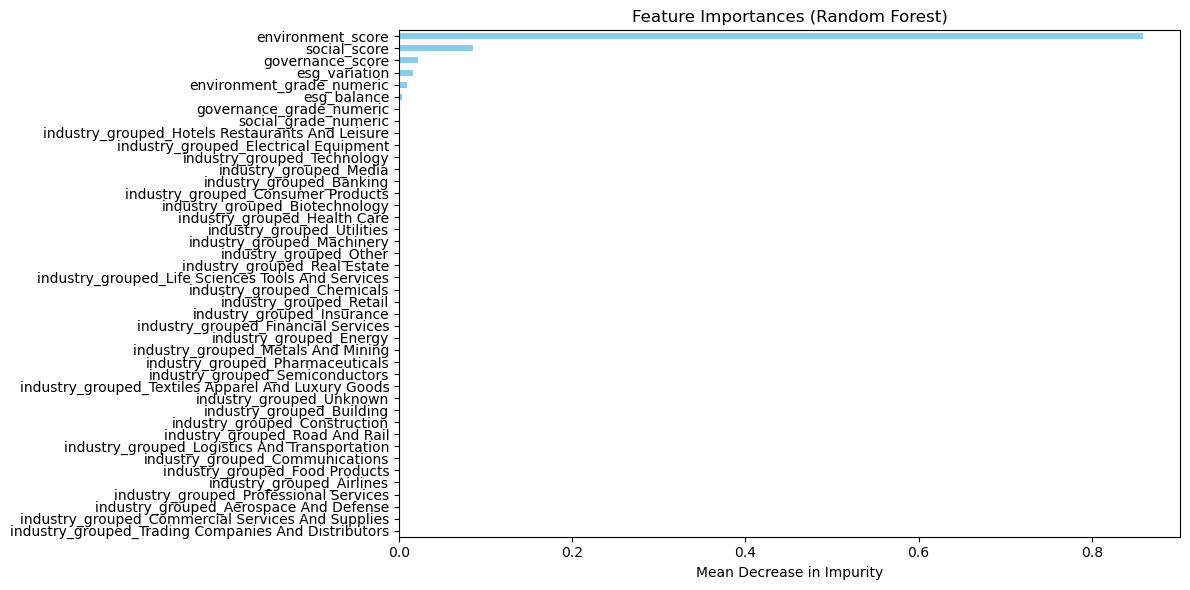

In [9]:
# Feature importance analysis
preprocessor.fit(X_train)
feature_names = numeric_features + list(
    preprocessor.named_transformers_['cat']
    .get_feature_names_out(['industry_grouped'])
)

importances = model.named_steps['regressor'].feature_importances_

# Plot feature importances
plt.figure(figsize=(12, 6))
pd.Series(importances, index=feature_names).sort_values().plot.barh(color='skyblue')
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Mean Decrease in Impurity")
plt.tight_layout()
plt.show()

**Environmental score is the strongest predictor of total ESG score.**

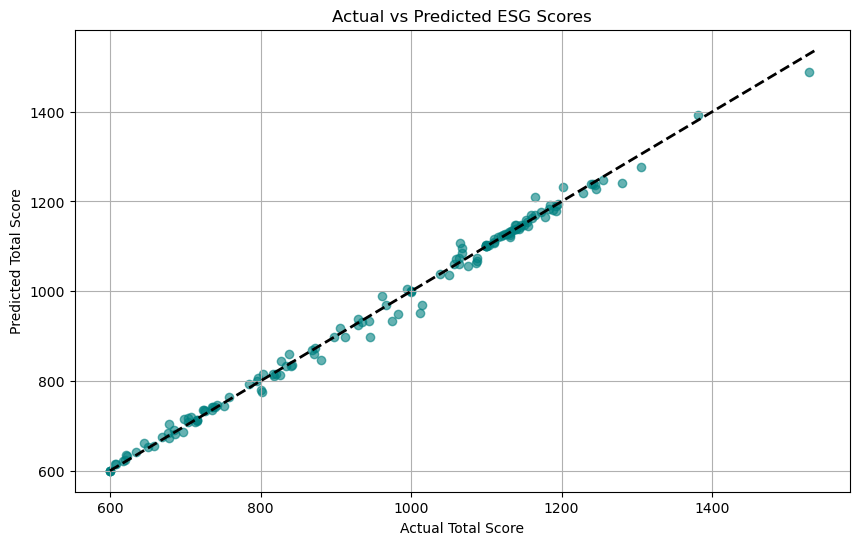

In [10]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Total Score')
plt.ylabel('Predicted Total Score')
plt.title('Actual vs Predicted ESG Scores')
plt.grid(True)
plt.show()

## Insights & Interpretation
- Total scores are highly predictable from E/S/G components.
- Environmental score dominates (0.96 correlation).
- Suggests total_score ≈ weighted sum of E + S + G.

In [14]:
print("Total score range:", df['total_score'].min(), "-", df['total_score'].max())
print("Relationship check:\n", df[['environment_score', 'social_score', 'governance_score', 'total_score']].corr())

Total score range: 600 - 1536
Relationship check:
                    environment_score  social_score  governance_score  \
environment_score           1.000000      0.671817          0.558682   
social_score                0.671817      1.000000          0.483364   
governance_score            0.558682      0.483364          1.000000   
total_score                 0.958551      0.810206          0.711576   

                   total_score  
environment_score     0.958551  
social_score          0.810206  
governance_score      0.711576  
total_score           1.000000  


### Key Findings:
- The model achieves near-perfect accuracy (R² = 0.99, RMSE = 14.98).
- Environmental score (0.96 correlation) is the strongest predictor of total ESG score.
- Results suggest that total ESG scores may be a weighted composite of E, S, and G sub-scores.

### Total Score Range: 600 - 1536

This indicates your ESG total scores span a wide range (936 points between min and max).

Given this context, your RMSE of 14.98 is extremely strong:

- The error represents just 1.6% of the total score range (14.98/936 ≈ 0.016).
- For perspective: Predicting a value between 600-1536 with ~15 points error is like estimating the temperature of a room (say, 60-100°F) within 0.3°F accuracy.

## Conclusion
    
This project demonstrates that ESG total scores are highly predictable from their underlying components, making ML overkill if a simple formula exists. However, the analysis provides valuable insights into ESG scoring dynamics, highlighting the dominance of environmental factors in overall ratings.

### Key Results

1. Exceptional Model Performance
- The Random Forest model achieved a near-perfect R² of 0.99 on both cross-validated and test data, indicating it explains 99% of the variance in ESG total scores.
- The RMSE of 14.98 is very low relative to the total score range (600–1536), meaning predictions are off by only ~1.6% on average.

2. Strong Feature Influence
- The environmental score (0.96 correlation) was the dominant predictor of the total score, followed by social (0.81) and governance (0.71).
- This suggests that the total score is likely a weighted composite of these three components, with environmental factors carrying the most weight.

3. Data-Driven Insights
- The model’s near-perfect accuracy implies that the total score is mathematically derived from the sub-scores rather than being an independent metric.
- If confirmed, this means the problem is more of a formula reconstruction than a predictive modeling task.